In [1]:
from agents import ModelAverager, DeltaHedge
from discrete_environments import DiscreteEnv
from data_generators import GBM_Generator
import utils
import numpy as np

In [2]:
buy_cost_pct = 0.001
sell_cost_pct = 0.001
S0 = 100

# Annualized
sigma = 0.01*np.sqrt(250) # 1% vol per day
r = 0.0

freq = 0.2 # corresponds to trading freq of 5x per day
ttm = 50
kappa = 0.1
n_actions = 41
gamma = 0.99

generator = GBM_Generator(S0, r, sigma, freq)

env_args = {
    "buy_cost_pct" : buy_cost_pct,
    "sell_cost_pct" : sell_cost_pct,
    "generator" : generator,
    "ttm" : ttm,
    "kappa" : kappa,
    "n_actions" : n_actions,
    "testing" : False
}

n_steps = 100
n_batches = 1

eps_func = utils.EpsFunction(n_steps).get_func()

In [3]:
env = DiscreteEnv(**env_args)
agent = ModelAverager(env, gamma)


In [4]:
agent.train(n_steps, n_batches, eps_func)

100%|██████████| 100/100 [00:00<00:00, 979.60it/s]


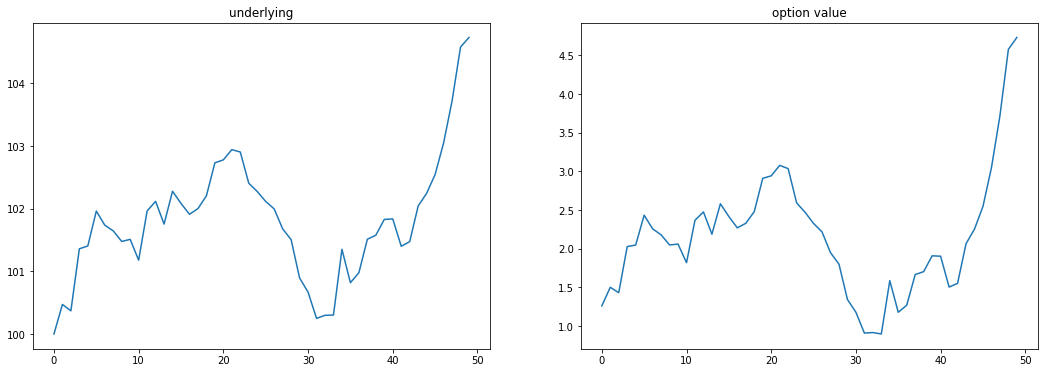

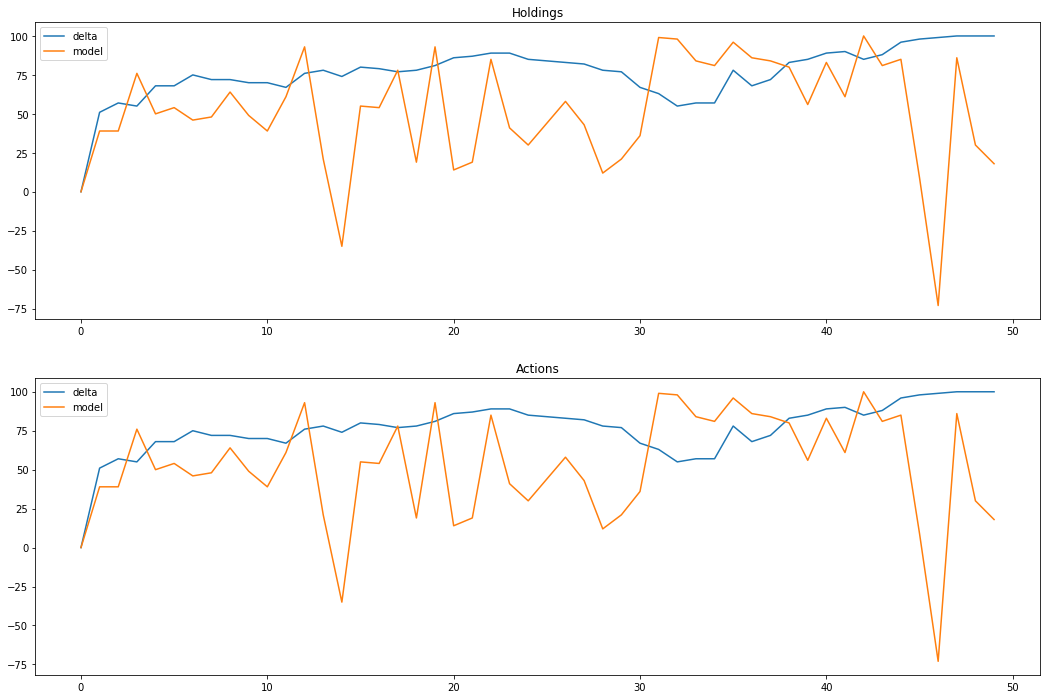

In [5]:
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq=freq, seed = 1234)
env_args["generator"] = generator
env_args["testing"] = True

test_env = DiscreteEnv(**env_args)
test_env_delta = DiscreteEnv(**env_args)

df = agent.test(test_env)

delta_agent = DeltaHedge(r, sigma, S0)
delta = delta_agent.test(test_env_delta)

utils.plot_decisions(delta, df)

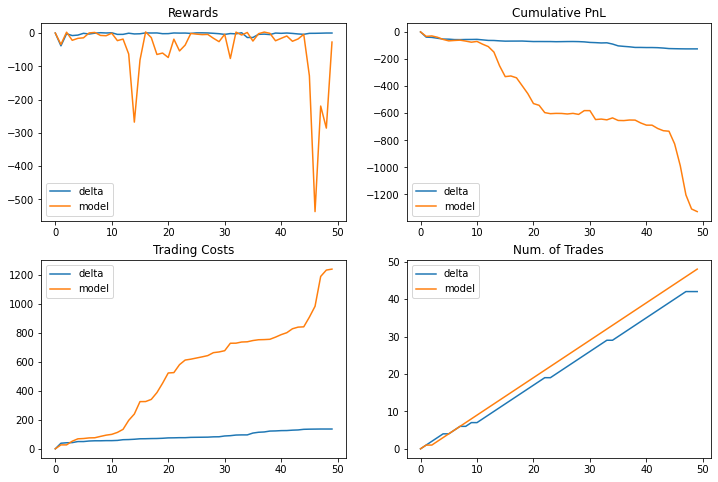

In [6]:
utils.plot_pnl(delta, df)

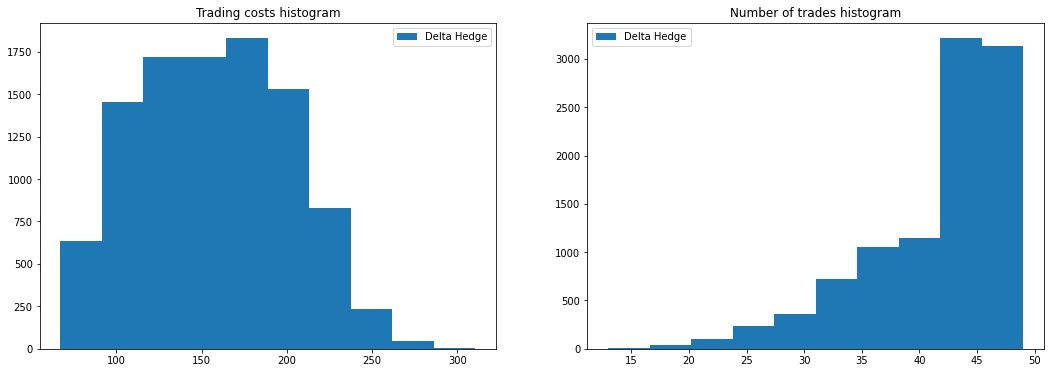

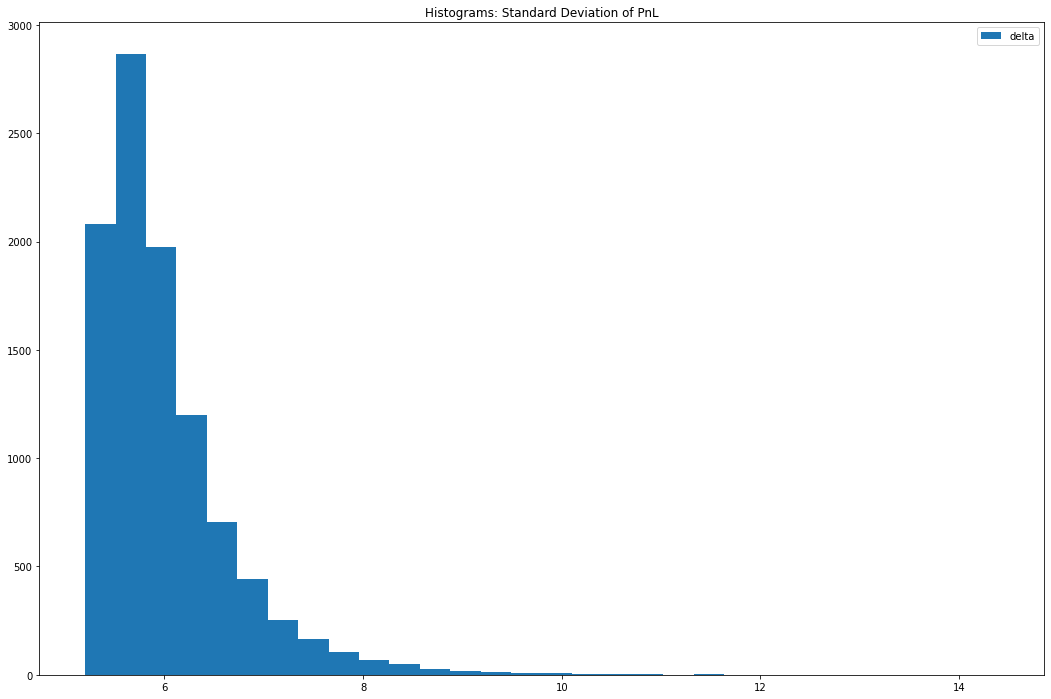

In [9]:
n_sim = 1000
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq = freq)
env_args["generator"] = generator
env_args["testing"] = True
pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict = utils.simulate_pnl2(delta_agent, n_sim, env_args)
utils.plot_pnl_hist2(pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict)

In [8]:
# n_sim = 10
# generator = GBM_Generator(r = r, sigma = sigma, S0 = S0)
# env_args["generator"] = generator
# env_args["testing"] = True
# pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict = utils.simulate_pnl(agent, delta_agent, n_sim, env_args)
# utils.plot_pnl_hist(pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict)